# Problema de Negócio

Os canais de reserva de hotéis online transformaram a forma como os clientes fazem suas reservas. No entanto, isso trouxe um desafio significativo: um número considerável de reservas são canceladas.

Para a HotelSmart, a alta taxa de cancelamento representa um problema financeiro e operacional. Cada cancelamento tem um **custo médio estimado de R$3.500**. Com uma projeção de **50.000 reservas para o próximo ano**, a perda potencial é substancial.

### Objetivo

Desenvolver um modelo de Machine Learning capaz de **prever com alta acurácia se uma reserva de hotel será cancelada ou não**. 

O modelo permitirá à HotelSmart:
1.  **Adotar medidas proativas:** Como oferecer pequenos descontos, upgrades ou confirmar a intenção de estadia para reservas de alto risco de cancelamento.
2.  **Otimizar a gestão de ocupação:** Liberar quartos de reservas de alto risco para outros clientes.
3.  **Reduzir perdas financeiras** e aumentar a lucratividade.

# Imports

In [143]:
import pandas as pd
import numpy as np
import pickle
import json

import seaborn as sns
import matplotlib.pyplot as plt 
from IPython.core.display import  HTML

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from scipy.stats import skew

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = (25, 12)
    plt.rcParams['font.size'] = 24

    display(HTML("<style>.container { width:100% !important; }</style>"))
    pd.options.display.max_columns = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

jupyter_settings()


def calculate_metrics(nome_algoritmo, y_true, y_pred):
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    df = pd.DataFrame({
        'Algoritmo': [nome_algoritmo],
        'Precisão': [precision],
        'Recall': [recall],
        'Acurácia': [accuracy]
    })

    return df


def cross_validation_kfold(model, X, y, k=5):

    num_folds = k
    scores = ['precision', 'recall', 'accuracy']
    
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    score_results = cross_validate(model, X, y, cv=kfold, scoring=scores)
    model_name = model.__class__.__name__
    precision_mean = score_results['test_precision'].mean() 
    recall_mean = score_results['test_recall'].mean()
    accuracy_mean = score_results['test_accuracy'].mean()

    result_dict = {
        'Model': model_name,
        'Precision': precision_mean,
        'Recall': recall_mean,
        'Accuracy': accuracy_mean
    }

    result_df = pd.DataFrame([result_dict])
    
    return result_df

def evaluate_model(model, X_test, y_test, model_name='Modelo'):
    """
    Calcula e exibe as métricas de classificação, AUC e a matriz de confusão para um dado modelo.

    Args:
        model: O modelo de machine learning treinado.
        X_test: Dados de teste (features).
        y_test: Dados de teste (alvo).
        model_name: (Opcional) Nome do modelo para o título do gráfico.
    """
    # Realizar previsões
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilidades para a classe positiva (1)

    # Calcular Métricas
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Imprimir Métricas
    print(f"--- Métricas de Avaliação para: {model_name} ---")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão (Precision): {precision:.4f}")
    print(f"Recall (Sensibilidade): {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC (Area Under the Curve): {auc:.4f}")
    print("-" * (40 + len(model_name)))

    # Calcular a Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)

    # Plotar a Matriz de Confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Não Cancelou', 'Cancelou'],
                yticklabels=['Não Cancelou', 'Cancelou'])
    plt.title(f'Matriz de Confusão - {model_name}', fontsize=16)
    plt.ylabel('Verdadeiro', fontsize=12)
    plt.xlabel('Previsto', fontsize=12)
    plt.show()

def selecionar_scaler(df, threshold_skew=1.0, outlier_zscore=3.0, plot=False):
    """
    Seleciona o melhor scaler para cada coluna numérica com base em skew e outliers.
    
    Parâmetros:
    - df: DataFrame com as variáveis numéricas
    - threshold_skew: limite de assimetria para considerar distribuição como normal (~<1)
    - outlier_zscore: limite para considerar um valor como outlier
    - plot: se True, plota histograma antes da transformação
    
    Retorna:
    - dict: dicionário com sugestão de scaler por coluna
    """
    resultado = {}
    
    for col in df.select_dtypes(include=np.number).columns:
        serie = df[col].dropna()
        col_skew = skew(serie)
        zscores = (serie - serie.mean()) / serie.std()
        n_outliers = np.sum(np.abs(zscores) > outlier_zscore)
        
        if plot:
            plt.figure(figsize=(6, 3))
            sns.histplot(serie, kde=True)
            plt.title(f'{col} | Skew={col_skew:.2f} | Outliers={n_outliers}')
            plt.show()
        
        # Lógica de escolha
        if n_outliers > len(serie) * 0.01 or abs(col_skew) > threshold_skew:
            scaler = 'RobustScaler'
        elif abs(col_skew) <= threshold_skew and n_outliers <= len(serie) * 0.01:
            scaler = 'MinMaxScaler'
        else:
            scaler = 'StandardScaler'
        
        resultado[col] = {
            'skew': round(col_skew, 2),
            'outliers': int(n_outliers),
            'scaler_sugerido': scaler
        }
        
    return pd.DataFrame(resultado).T


Populating the interactive namespace from numpy and matplotlib


# Carregamento dos Dados

In [4]:
df = pd.read_csv('./data/hotel.csv.csv')

In [5]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [6]:
df.columns

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')

# 1.0 Descrição dos Dados

In [7]:
df1 = df.copy()

In [153]:
df1.shape

(36136, 19)

## 1.2 Tipo dos Dados

In [9]:
df1.dtypes

Booking_ID                               object
no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                        object
required_car_parking_space                int64
room_type_reserved                       object
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                      object
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                           object
dtype: object

## 1.3 Check NA

In [10]:
df1.isnull().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

## 1.4 Estatísticas Descritivas

In [11]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(include=['object'])

In [12]:
# central tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean))
ct2 = pd.DataFrame(num_attributes.apply(np.median))
# dispersion
d1 = pd.DataFrame(num_attributes.apply(np.std))
d2 = pd.DataFrame(num_attributes.apply(min))
d3 = pd.DataFrame(num_attributes.apply(max))
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min()))
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew()))
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()))
# Percentiles
p1 = pd.DataFrame(num_attributes.apply(lambda x: x.quantile(0.25)))
p2 = pd.DataFrame(num_attributes.apply(lambda x: x.quantile(0.75)))
p3 = pd.DataFrame(num_attributes.apply(lambda x: x.quantile(0.50)))
p4 = pd.DataFrame(num_attributes.apply(lambda x: x.quantile(0.90)))
p5 = pd.DataFrame(num_attributes.apply(lambda x: x.quantile(0.95)))

# Concatenating all statistics
stats = pd.concat([ct1, ct2, d1, d2, d3, d4, d5, d6, p1, p2, p3, p4, p5], axis=1)   
stats.columns = [
    'media', 'mediana', 'desvio_padrao', 'minimo', 'maximo', 
    'amplitude', 'assimetria', 'curtose', 'percentil_25', 
    'percentil_75', 'percentil_50', 'percentil_90', 'percentil_95'	
]
stats = stats.round(2)
stats = stats.reset_index().rename(columns={'index': 'atributo'})

stats

,atributo,media,mediana,desvio_padrao,minimo,maximo,amplitude,assimetria,curtose,percentil_25,percentil_75,percentil_50,percentil_90,percentil_95
0,no_of_adults,1.84,2.00,0.52,0.0,4.0,4.0,-0.33,0.81,2.0,2.0,2.00,2.0,3.0
1,no_of_children,0.11,0.00,0.40,0.0,10.0,10.0,4.71,36.98,0.0,0.0,0.00,0.0,1.0
2,no_of_weekend_nights,0.81,1.00,0.87,0.0,7.0,7.0,0.74,0.30,0.0,2.0,1.00,2.0,2.0
3,no_of_week_nights,2.20,2.00,1.41,0.0,17.0,17.0,1.60,7.80,1.0,3.0,2.00,4.0,5.0
4,required_car_parking_space,0.03,0.00,0.17,0.0,1.0,1.0,5.41,27.31,0.0,0.0,0.00,0.0,0.0
5,lead_time,85.23,57.00,85.93,0.0,443.0,443.0,1.29,1.18,17.0,126.0,57.00,213.0,273.0
6,arrival_year,2017.82,2018.00,0.38,2017.0,2018.0,1.0,-1.67,0.79,2018.0,2018.0,2018.00,2018.0,2018.0
7,arrival_month,7.42,8.00,3.07,1.0,12.0,11.0,-0.35,-0.93,5.0,10.0,8.00,11.0,12.0
8,arrival_date,15.60,16.00,8.74,1.0,31.0,30.0,0.03,-1.16,8.0,23.0,16.00,28.0,29.0
9,repeated_guest,0.03,0.00,0.16,0.0,1.0,1.0,6.00,34.04,0.0,0.0,0.00,0.0,0.0


- **no_of_adults** igual a zero, pode ser erro
- **avg_price_per_room* igual a zero pode ser erro

In [13]:
cat_attributes.describe().T

,count,unique,top,freq
Booking_ID,36275,36275,INN22218,1
type_of_meal_plan,36275,4,Meal Plan 1,27835
room_type_reserved,36275,7,Room_Type 1,28130
market_segment_type,36275,5,Online,23214
booking_status,36275,2,Not_Canceled,24390


In [14]:
df1.columns

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')

## 1.5 Limpeza de dados

In [15]:
df1[df1['no_of_adults'] == 0]['no_of_children'].value_counts()

2    133
3      5
1      1
Name: no_of_children, dtype: int64

In [16]:
df1 = df1[df1['no_of_adults'] > 0]

#### Foi decidido realizar a limpeza das reservas sem adultos informados, pois não sabemos se pode ser um erro sistemico e assumir 1 outro valor para quantidade de adulto pode enviesar a analise

In [17]:
df1[df1['avg_price_per_room'] <= 0]

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
63,INN00064,1,0,0,1,Meal Plan 1,0,Room_Type 1,2,2017,9,10,Complementary,0,0,0,0.0,1,Not_Canceled
145,INN00146,1,0,0,2,Meal Plan 1,0,Room_Type 1,13,2018,6,1,Complementary,1,3,5,0.0,1,Not_Canceled
209,INN00210,1,0,0,0,Meal Plan 1,0,Room_Type 1,4,2018,2,27,Complementary,0,0,0,0.0,1,Not_Canceled
266,INN00267,1,0,0,2,Meal Plan 1,0,Room_Type 1,1,2017,8,12,Complementary,1,0,1,0.0,1,Not_Canceled
267,INN00268,1,0,2,1,Meal Plan 1,0,Room_Type 1,4,2017,8,23,Complementary,0,0,0,0.0,1,Not_Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35983,INN35984,1,0,0,1,Meal Plan 1,0,Room_Type 7,0,2018,6,7,Complementary,1,4,17,0.0,1,Not_Canceled
36080,INN36081,1,0,1,1,Meal Plan 1,0,Room_Type 7,0,2018,3,21,Complementary,1,3,15,0.0,1,Not_Canceled
36114,INN36115,1,0,0,1,Meal Plan 1,0,Room_Type 1,1,2018,3,2,Online,0,0,0,0.0,0,Not_Canceled
36217,INN36218,2,0,2,1,Meal Plan 1,0,Room_Type 2,3,2017,8,9,Online,0,0,0,0.0,2,Not_Canceled


#### Para os casos de avg_price_per_room igual a zero, foi decidido colocar uma premissa de que esses dados podem ser oriundos de reservas promocionais, brindes etc, e por isso o valor está zerado

# 2.0 Feature Engineering

In [18]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

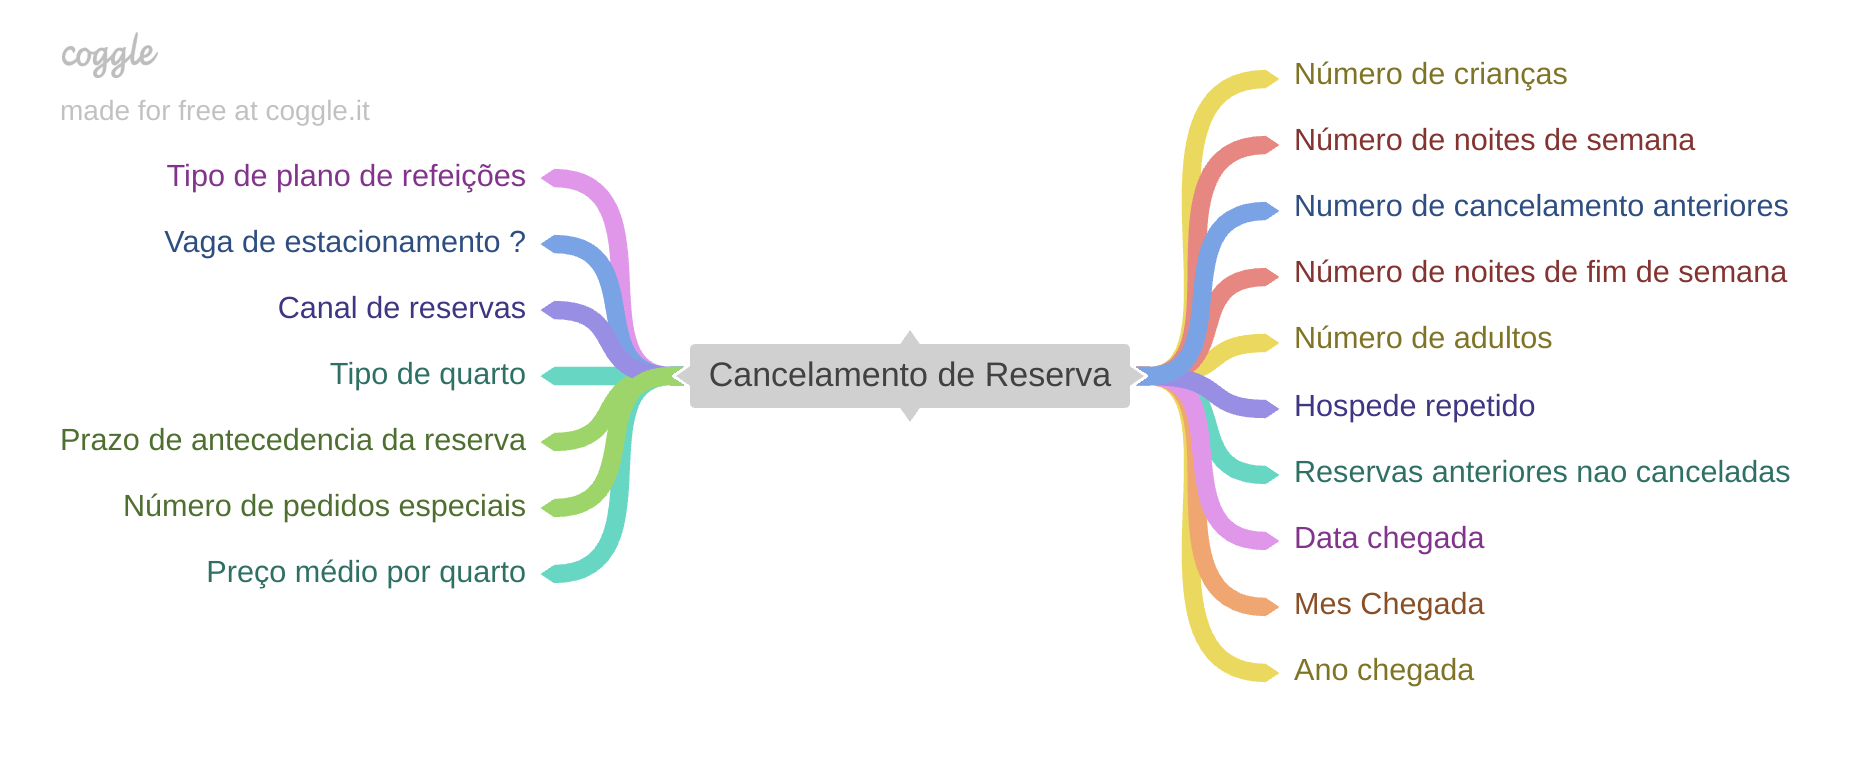

## 2.2 Lista de Hipóteses

- O canal de reservas online apresenta maior taxa de cancelamento

- Hóspedes recorrentes cancelam menos

- O preço ofertado influencia na taxa de cancelamento

- Pessoas com crianças inclusas na reserva tendem a ter mais cancelamentos

- Quanto maior a antecipação da reserva maior a taxa de cancelamento

- Alguns meses (com feriados) possuem maior taxa de cancelamento

- Reservas com pedidos especiais são mais prováveis de serem confirmadas, pois indicam um maior engajamento do cliente

## 2.3 Feature Engineering

In [19]:
df2.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [22]:
# Total de noites de estadia
df2['total_nights'] = df2['no_of_weekend_nights'] + df2['no_of_week_nights']

# Total hospedes na reserva
df2['total_guests'] = df2['no_of_adults'] + df2['no_of_children']

# Viagem familiar
df2['family_trip'] = df2.apply(lambda x: 1 if x['no_of_children'] > 0 else 0, axis=1)

# Data completa - YYYY/MM/DD
df2['arrival_date_full'] = pd.to_datetime(
    df2['arrival_year'].astype(str) + '/' +
    df2['arrival_month'].astype(str) + '/' +
    df2['arrival_date'].astype(str),
    errors='coerce'
)

# Foi avaliado que dia 29 de Fevereiro de 2018 é uma data inválida, com isso, decidi remover nesse ciclo esses dados.
df2 = df2[~df2['arrival_date_full'].isnull()]

# Dia da semana
df2['day_of_week'] = df2['arrival_date_full'].dt.dayofweek

# Semana do ano
df2['week_of_year'] = df2['arrival_date_full'].dt.isocalendar().week 

# Razão de cancelamentos anteriores
numerator = df2['no_of_previous_cancellations']
denominator = df2['no_of_previous_cancellations'] + df2['no_of_previous_bookings_not_canceled']
df2['cancellation_ratio_previous'] = numerator / denominator

df2['cancellation_ratio_previous'].fillna(0, inplace=True)


In [23]:
# Target
df2['booking_status'] = df2['booking_status'].map({'Not_Canceled': 0, 'Canceled': 1})

# 3.0 EDA

In [24]:
df3 = df2.copy()

## 3.1 Análise Univariada

### 3.1.1 Target

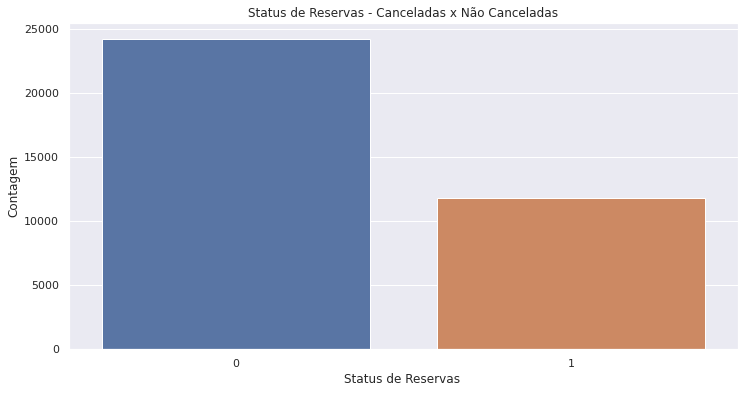

In [25]:
aux = df3.copy()
aux['booking_status'] = aux['booking_status'].astype(str)

plt.figure(figsize=(12, 6))
sns.countplot(data=aux, x='booking_status')
plt.title('Status de Reservas - Canceladas x Não Canceladas')
plt.xlabel('Status de Reservas ')
plt.ylabel('Contagem')
plt.show()


In [87]:
df3.booking_status.value_counts(normalize=True)

0    0.672179
1    0.327821
Name: booking_status, dtype: float64

### 3.1.2 Numeric Variables

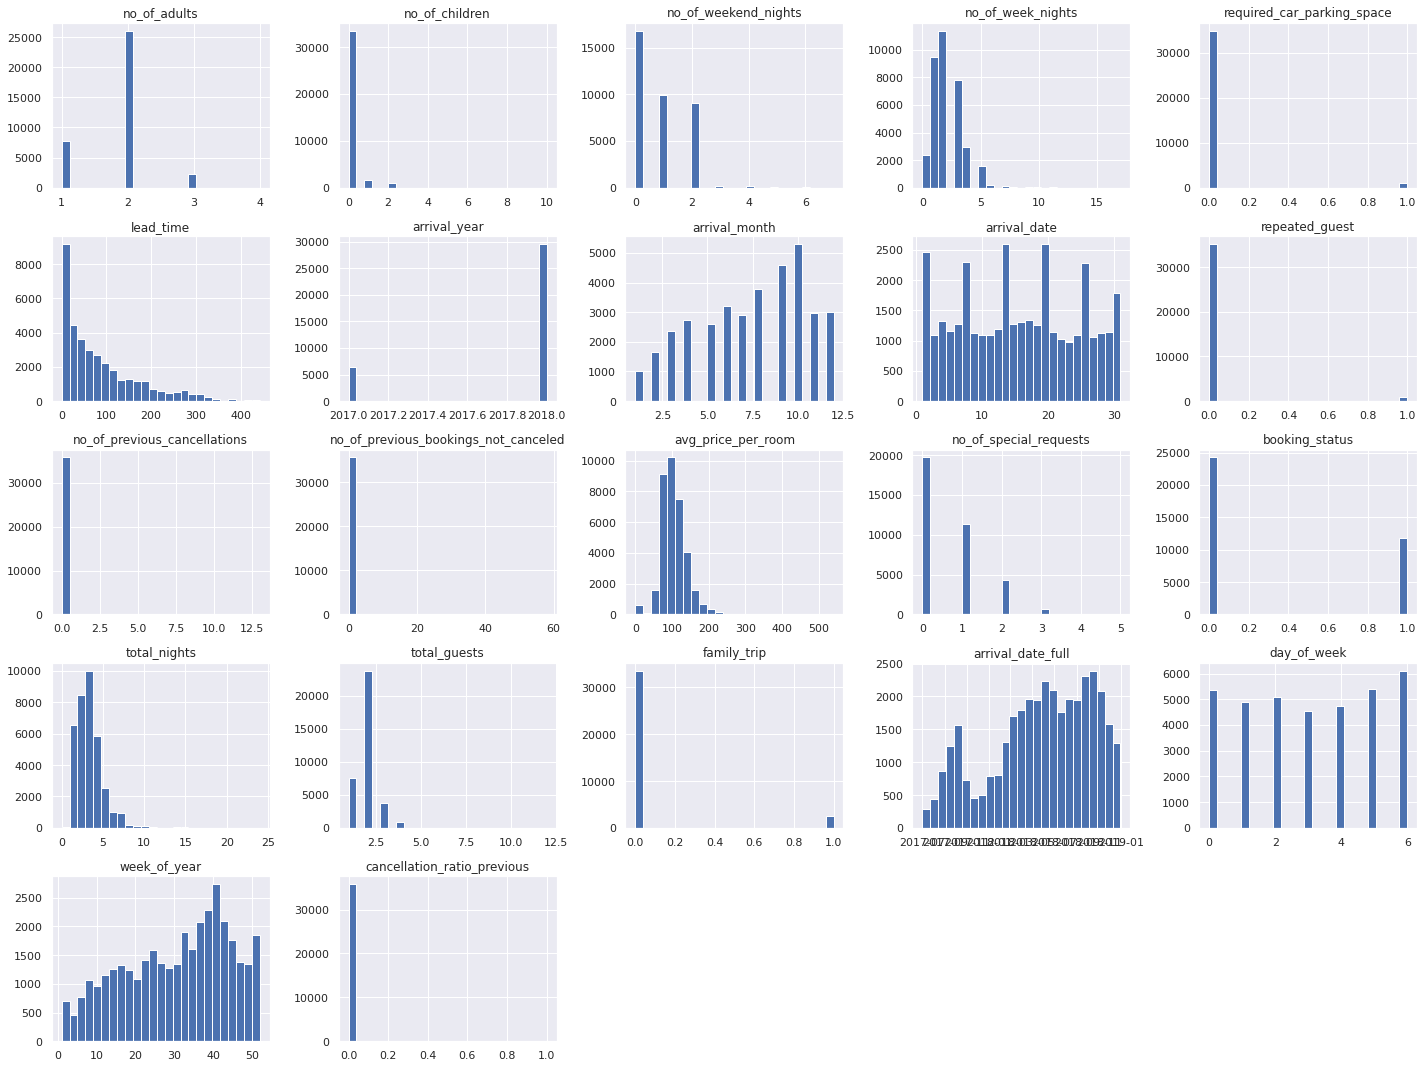

In [26]:
num_attributes2 = df3.select_dtypes(exclude=['category', 'object'])

num_attributes2.hist(bins=25, figsize=(20, 15))
plt.tight_layout()
plt.show()

### 3.1.3 Categóricas

In [27]:
cat_attributes2 = df3.select_dtypes(include=['category', 'object'])

cat_attributes2.head()

,Booking_ID,type_of_meal_plan,room_type_reserved,market_segment_type
0,INN00001,Meal Plan 1,Room_Type 1,Offline
1,INN00002,Not Selected,Room_Type 1,Online
2,INN00003,Meal Plan 1,Room_Type 1,Online
3,INN00004,Meal Plan 1,Room_Type 1,Online
4,INN00005,Not Selected,Room_Type 1,Online


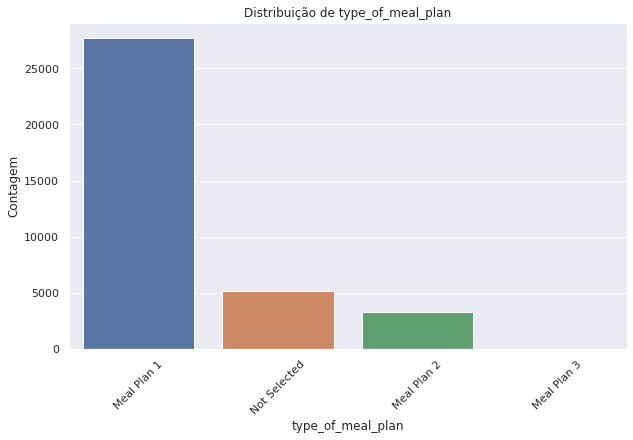

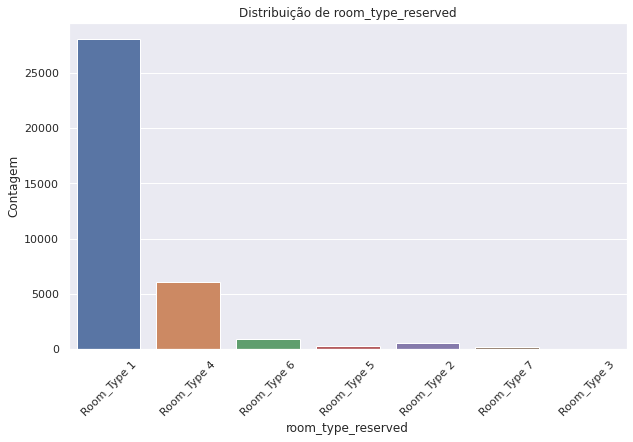

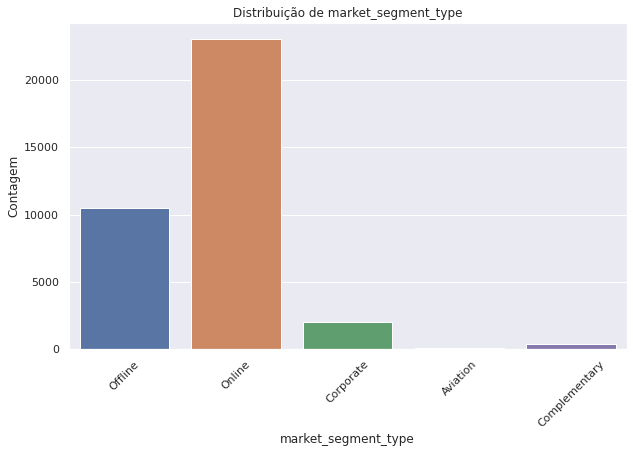

In [28]:
cat_attributes2 = df3.select_dtypes(include=['category', 'object']).drop('Booking_ID', axis=1)

for col in cat_attributes2.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df3, x=col)
    plt.title(f'Distribuição de {col}')
    plt.xlabel(col)
    plt.ylabel('Contagem')
    plt.xticks(rotation=45)
    plt.show()

## 3.2 Análise Bivariada

- O canal de reservas online apresenta maior taxa de cancelamento

- A taxa de cancelamento é menor para pessoas com histórico de não cancelamento

- O preço ofertado influencia na taxa de cancelamento

- Pessoas com crianças inclusas na reserva tendem a ter mais cancelamentos

- Quanto maior a antecipação da reserva maior a taxa de cancelamento

- Alguns meses (com feriados) possuem maior taxa de cancelamento

- Reservas com pedidos especiais são mais prováveis de serem confirmadas, pois indicam um maior engajamento do cliente

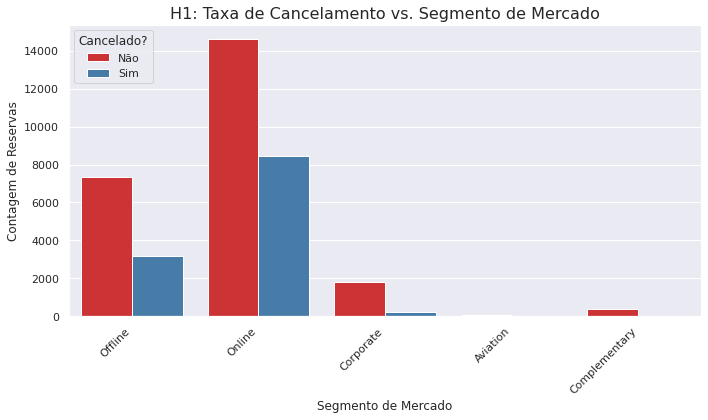

In [29]:
# H1: O canal de reservas online apresenta maior taxa de cancelamento

plt.figure(figsize=(10, 6))
sns.countplot(data=df3, x='market_segment_type', hue='booking_status', palette='Set1')
plt.title('H1: Taxa de Cancelamento vs. Segmento de Mercado', fontsize=16)
plt.xlabel('Segmento de Mercado', fontsize=12)
plt.ylabel('Contagem de Reservas', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cancelado?', labels=['Não', 'Sim'])
plt.tight_layout()
plt.show()

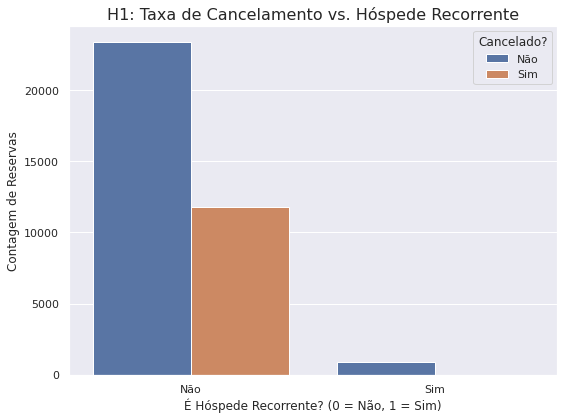

In [30]:
# H2 - Hóspedes recorrentes cancelam menos

plt.figure(figsize=(8, 6))
sns.countplot(data=df3, x='repeated_guest', hue='booking_status')
plt.title('H1: Taxa de Cancelamento vs. Hóspede Recorrente', fontsize=16)
plt.xlabel('É Hóspede Recorrente? (0 = Não, 1 = Sim)', fontsize=12)
plt.ylabel('Contagem de Reservas', fontsize=12)
plt.legend(title='Cancelado?', labels=['Não', 'Sim'])
plt.xticks([0, 1], ['Não', 'Sim'])
plt.tight_layout()
plt.show()

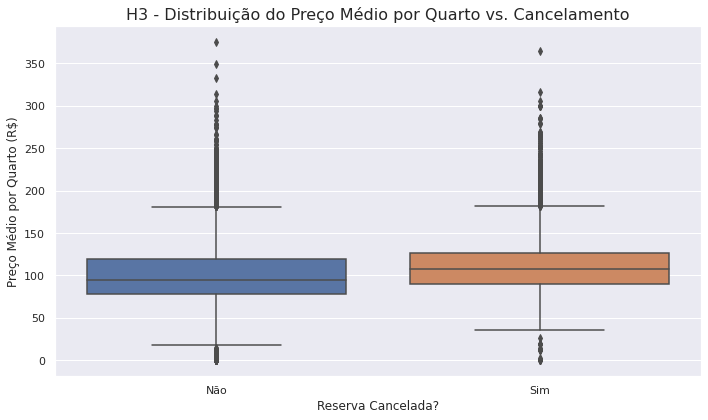

In [31]:
# O preço ofertado influencia na taxa de cancelamento - 

df_filtered_price = df3[df3['avg_price_per_room'] < 400]
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered_price, x='booking_status', y='avg_price_per_room')
plt.title('H3 - Distribuição do Preço Médio por Quarto vs. Cancelamento', fontsize=16)
plt.xlabel('Reserva Cancelada?', fontsize=12)
plt.ylabel('Preço Médio por Quarto (R$)', fontsize=12)
plt.xticks([0, 1], ['Não', 'Sim'])
plt.tight_layout()

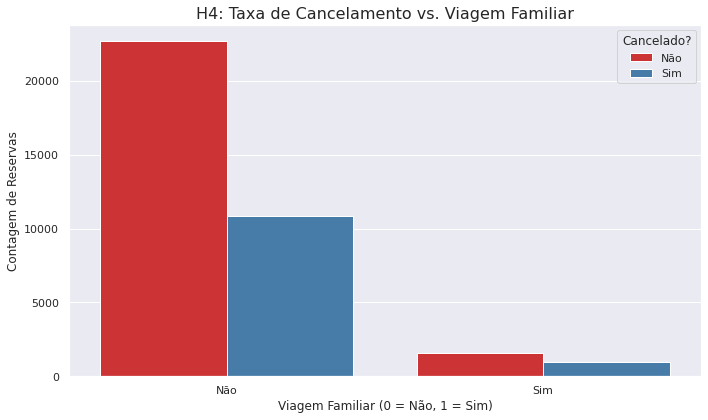

In [32]:
# Pessoas com crianças inclusas na reserva tendem a ter mais cancelamentos 
plt.figure(figsize=(10, 6))
sns.countplot(data=df3, x='family_trip', hue='booking_status', palette='Set1')
plt.title('H4: Taxa de Cancelamento vs. Viagem Familiar', fontsize=16)
plt.xlabel('Viagem Familiar (0 = Não, 1 = Sim)', fontsize=12)
plt.ylabel('Contagem de Reservas', fontsize=12)
plt.xticks([0, 1], ['Não', 'Sim'])
plt.legend(title='Cancelado?', labels=['Não', 'Sim'])
plt.tight_layout()
plt.show()

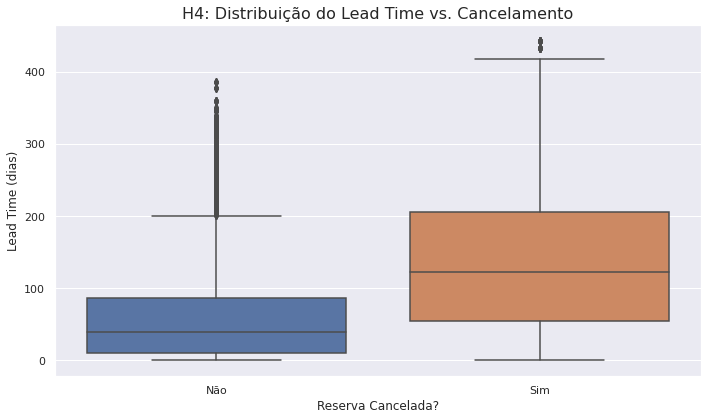

In [33]:
# Quanto maior a antecipação da reserva maior a taxa de cancelamento

plt.figure(figsize=(10, 6))
sns.boxplot(data=df3, x='booking_status', y='lead_time')
plt.title('H4: Distribuição do Lead Time vs. Cancelamento', fontsize=16)
plt.xlabel('Reserva Cancelada?', fontsize=12)
plt.ylabel('Lead Time (dias)', fontsize=12)
plt.xticks([0, 1], ['Não', 'Sim'])
plt.tight_layout()

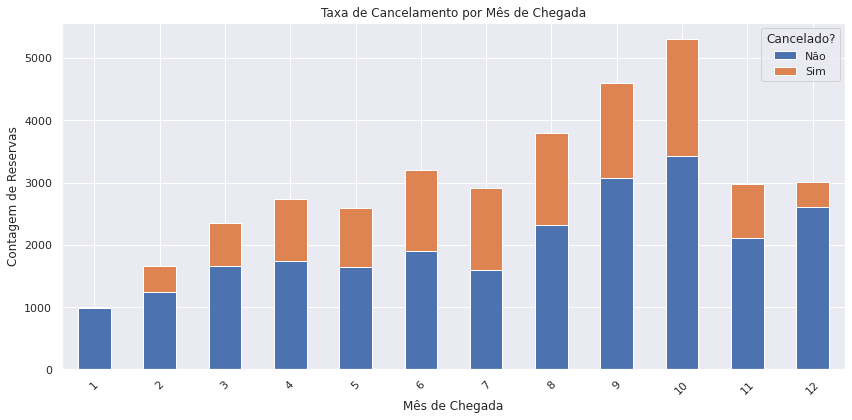

In [34]:
# Alguns meses (com feriados) possuem maior taxa de cancelamento - month x booking_status
df3.groupby(['arrival_month', 'booking_status']).size().unstack().plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Taxa de Cancelamento por Mês de Chegada')
plt.xlabel('Mês de Chegada')
plt.ylabel('Contagem de Reservas')
plt.xticks(rotation=45)
plt.legend(title='Cancelado?', labels=['Não', 'Sim'])
plt.tight_layout()
plt.show()


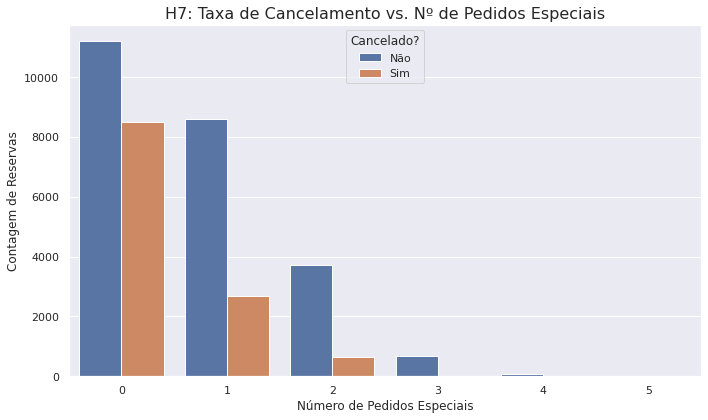

In [35]:
# Reservas com pedidos especiais são mais prováveis de serem confirmadas, pois indicam um maior engajamento do cliente
plt.figure(figsize=(10, 6))
sns.countplot(data=df3, x='no_of_special_requests', hue='booking_status')
plt.title('H7: Taxa de Cancelamento vs. Nº de Pedidos Especiais', fontsize=16)
plt.xlabel('Número de Pedidos Especiais', fontsize=12)
plt.ylabel('Contagem de Reservas', fontsize=12)
plt.legend(title='Cancelado?', labels=['Não', 'Sim'])
plt.tight_layout()
plt.show()

## 3.1 Análise Multivariada

### 3.3.1 Variáveis Numéricas

/home/felipe_rastelli/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


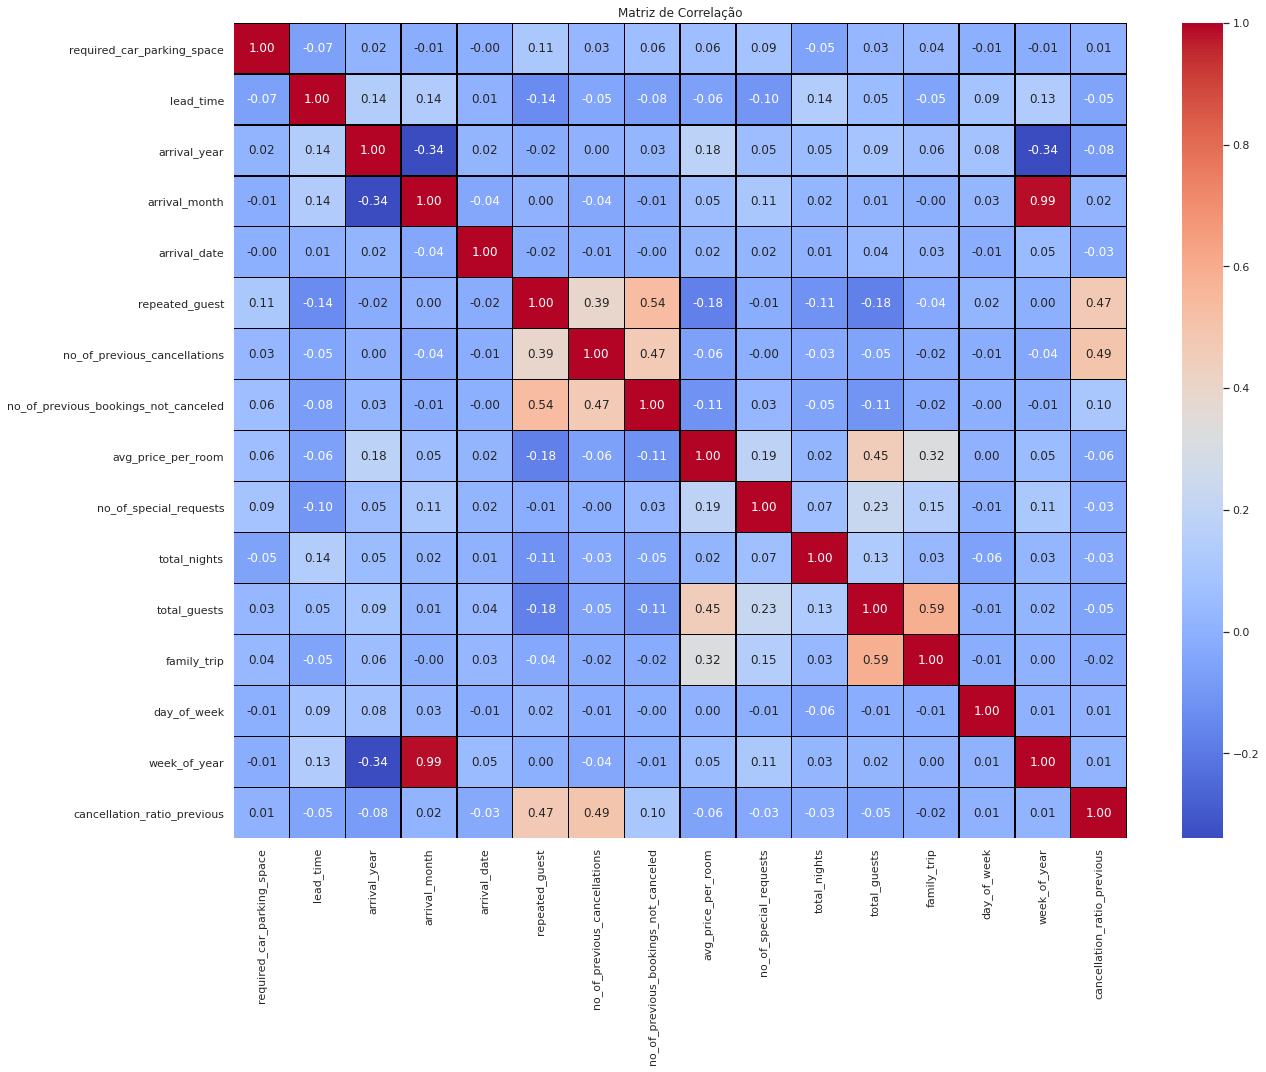

In [36]:
num_attributes3 = df3.select_dtypes(exclude=['category', 'object'])
num_attributes3.drop(columns=['booking_status', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights'], inplace=True)

corr = num_attributes3.corr(method='pearson')
plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Matriz de Correlação')
plt.show()

### 3.3.2 Variáveis Categóricas - Obs: Não consegui executar na minha máquina atual

In [37]:
# from  scipy import stats as ss

# def cramer_v(x, y):
#     cm = pd.crosstab(x, y).values
#     n = cm.sum()
#     r, k = cm.shape

#     chi2 = ss.chi2_contingency(cm)[0]
#     chi2corr = max(0, chi2 - (k - 1) * (r - 1))

#     kcorr = k - (k - 1) ** 2 / n
#     rcorr = r - (r - 1) ** 2 / n

#     return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

In [38]:
# aux = df3.copy()
# aux['booking_status'] = aux['booking_status'].astype(str)

# a = aux.select_dtypes(include=['category', 'object'])
# categorical_columns = a.columns

# cramer_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
# for i in categorical_columns:
#     for j in categorical_columns:
#         cramer_v_matrix.loc[i, j] = cramer_v(aux[i], aux[j])
# cramer_v_matrix = cramer_v_matrix.astype(float) 
# plt.figure(figsize=(10, 10))
# sns.heatmap(cramer_v_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, linecolor='black')
# plt.title('Matriz de Correlação Cramer V')
# plt.show()


# 4.0 Data Modelling

In [123]:
df4 = df3.copy()

In [50]:
df4_aux = df4.select_dtypes(exclude=['category', 'object']).drop(columns=['booking_status','family_trip','required_car_parking_space', 
                                                                          'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest', 'week_of_year', 'arrival_date_full'])

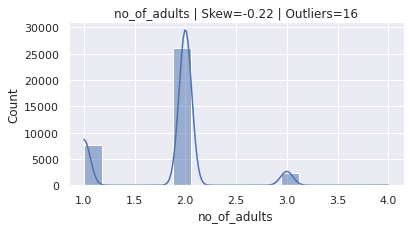

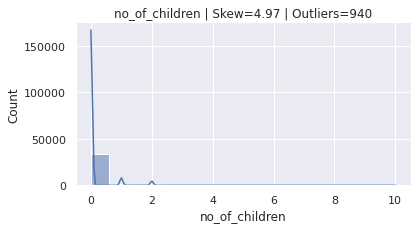

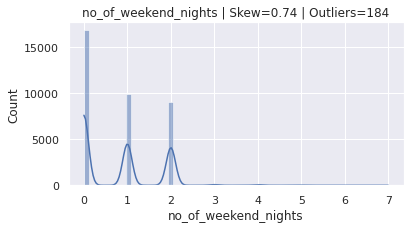

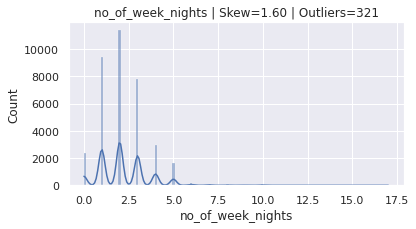

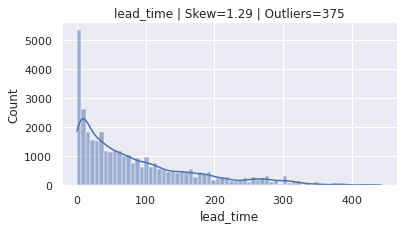

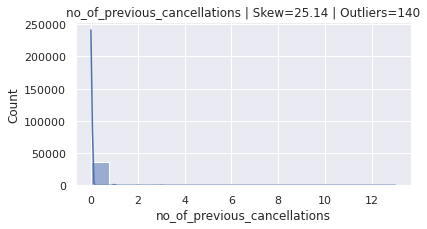

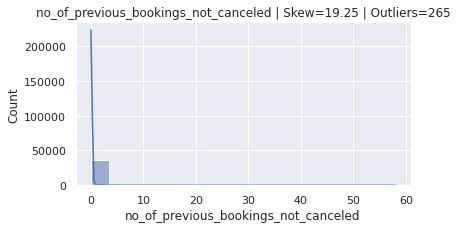

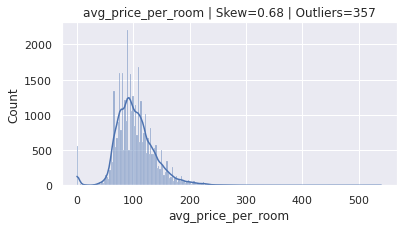

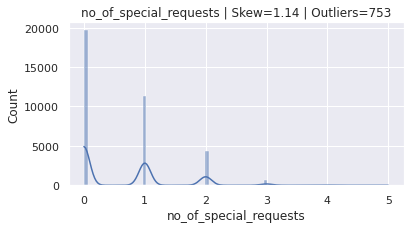

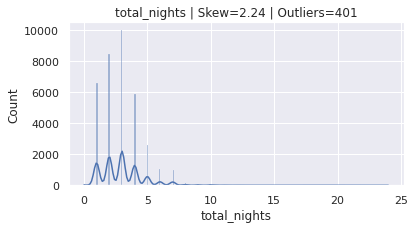

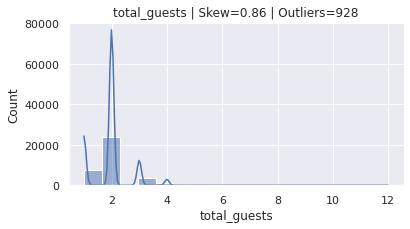

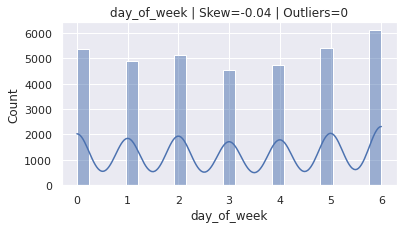

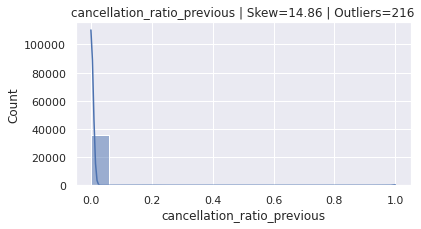

,skew,outliers,scaler_sugerido
no_of_adults,-0.22,16,MinMaxScaler
no_of_children,4.97,940,RobustScaler
no_of_weekend_nights,0.74,184,MinMaxScaler
no_of_week_nights,1.6,321,RobustScaler
lead_time,1.29,375,RobustScaler
no_of_previous_cancellations,25.14,140,RobustScaler
no_of_previous_bookings_not_canceled,19.25,265,RobustScaler
avg_price_per_room,0.68,357,MinMaxScaler
no_of_special_requests,1.14,753,RobustScaler
total_nights,2.24,401,RobustScaler


In [51]:
selecionar_scaler(df4_aux, threshold_skew=1.0, outlier_zscore=3.0, plot=True)

## 4.1 Normalization

## 4.2 Rescaling

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
rescale_mm = MinMaxScaler()
rescale_rs = RobustScaler()

# no_of_adults
df4['no_of_adults'] = rescale_mm.fit_transform(df4[['no_of_adults']])

# no_of_children
df4['no_of_children'] = rescale_rs.fit_transform(df4[['no_of_children']])

# no_of_weekend_nights
df4['no_of_weekend_nights'] = rescale_mm.fit_transform(df4[['no_of_weekend_nights']])

# no_of_week_nights
df4['no_of_week_nights'] = rescale_rs.fit_transform(df4[['no_of_week_nights']])

# lead_time
df4['lead_time'] = rescale_rs.fit_transform(df4[['lead_time']])

# total_nights
df4['total_nights'] = rescale_rs.fit_transform(df4[['total_nights']])

# total_guests
df4['total_guests'] = rescale_rs.fit_transform(df4[['total_guests']])

# avg_price_per_room
df4['avg_price_per_room'] = rescale_mm.fit_transform(df4[['avg_price_per_room']])

# no_of_special_requests
df4['no_of_special_requests'] = rescale_rs.fit_transform(df4[['no_of_special_requests']])

# day_of_week
df4['day_of_week'] = rescale_mm.fit_transform(df4[['day_of_week']])

# week_of_year
df4['week_of_year'] = rescale_mm.fit_transform(df4[['week_of_year']])

In [125]:
# Versão com pickle para salvar os scalers

def rescale_minmax(data, column):
    scaler = MinMaxScaler()
    data[[column]] = scaler.fit_transform(data[[column]])
    pickle.dump(scaler, open(f'parameters/scaler_{column}.pkl', 'wb'))
    return data

def rescale_robust(data, column):
    scaler = RobustScaler()
    data[[column]] = scaler.fit_transform(data[[column]])
    pickle.dump(scaler, open(f'parameters/scaler_{column}.pkl', 'wb'))
    return data

mm_columns = ['no_of_adults', 'no_of_weekend_nights', 'avg_price_per_room',
              'day_of_week', 'week_of_year']
rs_columns = ['no_of_children', 'no_of_week_nights', 'lead_time', 'total_nights',
              'total_guests', 'no_of_special_requests']

for column in mm_columns:
    df4 = rescale_minmax(df4, column)
for column in rs_columns:
    df4 = rescale_robust(df4, column)

## 4.3 Encoding

In [ ]:
le = LabelEncoder()

# market_segment_type
df4['market_segment_type'] = le.fit_transform(df4['market_segment_type'])

# type_of_meal_plan
df4['type_of_meal_plan'] = le.fit_transform(df4['type_of_meal_plan'])

# room_type_reserved
df4['room_type_reserved'] = le.fit_transform(df4['room_type_reserved'])

In [126]:
# Versão com pickle para salvar os label encoders

le = LabelEncoder()

def encode_label(data, column):
    data[column] = le.fit_transform(data[[column]])
    pickle.dump(le, open(f'parameters/label_encoder_{column}.pkl', 'wb'))
    return data

label_columns = [
    'market_segment_type',
    'type_of_meal_plan',
    'room_type_reserved'
]

for column in label_columns:
    df4 = encode_label(df4, column)

/home/felipe_rastelli/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/felipe_rastelli/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/felipe_rastelli/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [55]:
df4.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,total_nights,total_guests,family_trip,arrival_date_full,day_of_week,week_of_year,cancellation_ratio_previous
0,INN00001,0.333333,0.0,0.142857,0.0,0,0,0,1.532110,2017,10,2,3,0,0,0,0.120370,0.0,0,0.0,0.0,0,2017-10-02,0.000000,0.764706,0.0
1,INN00002,0.333333,0.0,0.285714,0.5,3,0,0,-0.477064,2018,11,6,4,0,0,0,0.197556,1.0,0,1.0,0.0,0,2018-11-06,0.166667,0.862745,0.0
2,INN00003,0.000000,0.0,0.285714,-0.5,0,0,0,-0.513761,2018,2,28,4,0,0,0,0.111111,0.0,1,0.0,-1.0,0,2018-02-28,0.333333,0.156863,0.0
3,INN00004,0.333333,0.0,0.000000,0.0,0,0,0,1.412844,2018,5,20,4,0,0,0,0.185185,0.0,1,-0.5,0.0,0,2018-05-20,1.000000,0.372549,0.0
4,INN00005,0.333333,0.0,0.142857,-0.5,3,0,0,-0.082569,2018,4,11,4,0,0,0,0.175000,0.0,1,-0.5,0.0,0,2018-04-11,0.333333,0.274510,0.0


# 5.0 Feature Selection

In [56]:
df5 = df4.copy()

## 5.1 Feature Importance - Tree

In [57]:
from sklearn.model_selection import train_test_split

X = df5.drop(columns=['booking_status', 'Booking_ID', 'arrival_date_full', 'arrival_year', 'arrival_month', 'arrival_date'])
y = df5['booking_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)   

In [58]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train, y_train)

importances = model.feature_importances_

In [59]:
importances

array([1.36279018e-02, 3.86294160e-03, 2.75057000e-02, 3.45734863e-02,
       1.91910077e-02, 6.07289739e-03, 1.62185349e-02, 3.27673035e-01,
       5.08765221e-02, 1.86311434e-03, 2.82516631e-04, 1.41464654e-03,
       1.66302397e-01, 9.72111140e-02, 4.20395987e-02, 1.61481036e-02,
       2.65965505e-03, 4.93485330e-02, 1.22863599e-01, 2.64695726e-04])

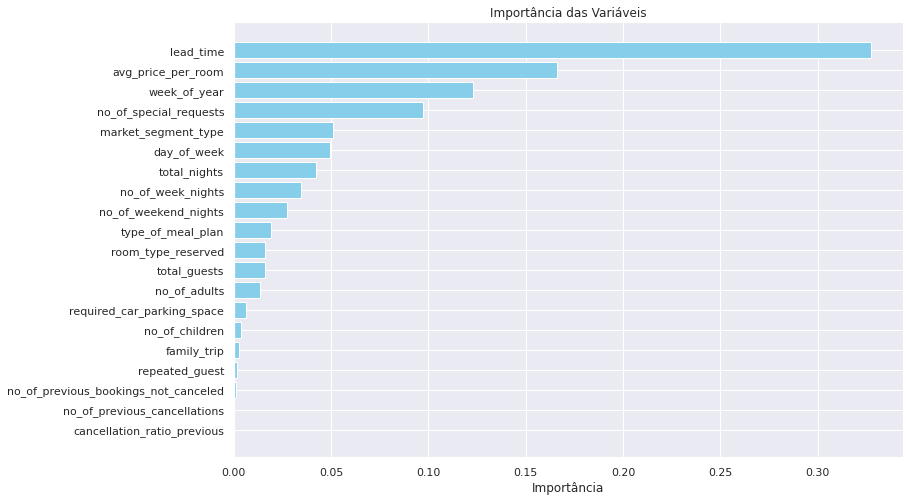

In [60]:
feature_names = X_train.columns
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
plt.xlabel('Importância')
plt.title('Importância das Variáveis')
plt.gca().invert_yaxis()
plt.show()

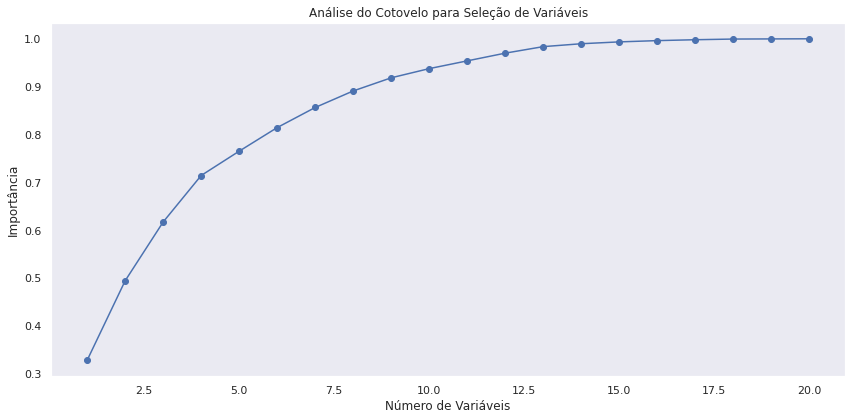

In [61]:
# Knee analysis
num_features = len(sorted_feature_names)
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_features + 1), np.cumsum(sorted_importances), marker='o', linestyle='-')
plt.xlabel('Número de Variáveis')
plt.ylabel('Importância')
plt.title('Análise do Cotovelo para Seleção de Variáveis')
plt.grid()
plt.tight_layout()
plt.show()

## 5.2 Regressions

### 5.2.1 Lasso

In [62]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

for feature, coef in zip(X_train.columns, lasso.coef_):
    print(f"{feature}: {coef:.4f}") 

no_of_adults: 0.0000
no_of_children: 0.0000
no_of_weekend_nights: 0.0000
no_of_week_nights: 0.0000
type_of_meal_plan: 0.0075
required_car_parking_space: -0.0000
room_type_reserved: 0.0222
lead_time: 0.2355
market_segment_type: 0.1127
repeated_guest: 0.0000
no_of_previous_cancellations: -0.0000
no_of_previous_bookings_not_canceled: 0.0000
avg_price_per_room: 0.0000
no_of_special_requests: -0.1475
total_nights: 0.0043
total_guests: 0.0067
family_trip: 0.0000
day_of_week: 0.0000
week_of_year: -0.0000
cancellation_ratio_previous: -0.0000


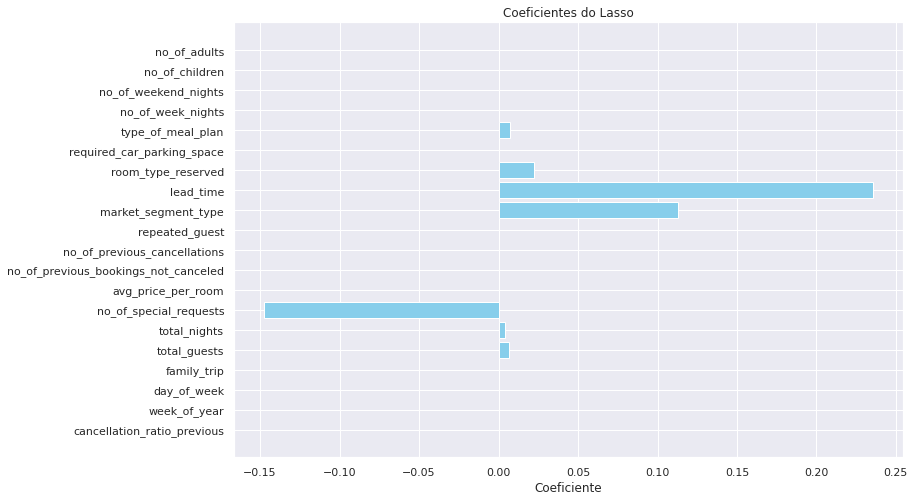

In [63]:
coefs = lasso.coef_
feature_names = X_train.columns

plt.figure(figsize=(12, 8))
plt.barh(feature_names, coefs, color='skyblue')
plt.xlabel('Coeficiente')
plt.title('Coeficientes do Lasso')
plt.gca().invert_yaxis()
plt.show()

### 5.2.2 Ridge

In [64]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.01)
ridge.fit(X_train, y_train)

for feature, coef in zip(X_train.columns, ridge.coef_):
    print(f"{feature}: {coef:.4f}") 

no_of_adults: 0.0150
no_of_children: -0.0527
no_of_weekend_nights: 0.0172
no_of_week_nights: -0.0238
type_of_meal_plan: 0.0229
required_car_parking_space: -0.1266
room_type_reserved: 0.0084
lead_time: 0.2576
market_segment_type: 0.1083
repeated_guest: 0.1468
no_of_previous_cancellations: -0.0029
no_of_previous_bookings_not_canceled: 0.0041
avg_price_per_room: 1.2406
no_of_special_requests: -0.1726
total_nights: 0.0364
total_guests: -0.0075
family_trip: 0.1057
day_of_week: 0.0165
week_of_year: -0.0795
cancellation_ratio_previous: -0.1954


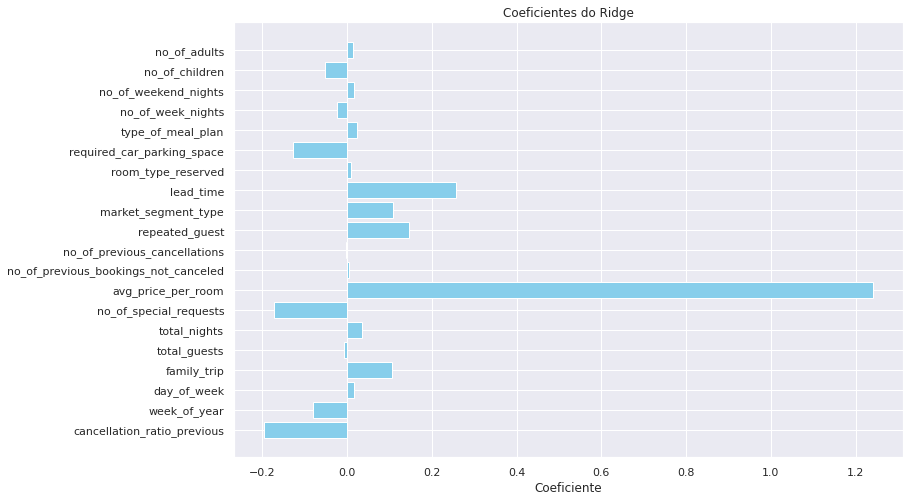

In [65]:
coefs = ridge.coef_
feature_names = X_train.columns

plt.figure(figsize=(12, 8))
plt.barh(feature_names, coefs, color='skyblue')
plt.xlabel('Coeficiente')
plt.title('Coeficientes do Ridge')
plt.gca().invert_yaxis()
plt.show()

## 5.3 Boruta

In [66]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1)
boruta = BorutaPy(
    rf,
    n_estimators='auto',
    verbose=2,
    random_state=42
).fit(X_train.values, y_train.values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	15


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	15


In [68]:
cols_selected = boruta.support_.tolist()
selected_features = X_train.iloc[:, cols_selected].columns.tolist()
print("Variáveis selecionadas pelo Boruta:")
print(selected_features)

Variáveis selecionadas pelo Boruta:
['lead_time', 'market_segment_type', 'avg_price_per_room', 'no_of_special_requests', 'week_of_year']


# 6.0 Machine Learning Models

In [69]:
boruta_columns = X_train.columns[boruta.support_]

In [70]:
df6 = df5.copy()

In [71]:
X = df6[boruta_columns]
y = df6['booking_status']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

## 6.1 Random Forest

--- Métricas de Avaliação para: Random Forest ---
Acurácia: 0.8849
Precisão (Precision): 0.8466
Recall (Sensibilidade): 0.7926
F1-Score: 0.8187
AUC (Area Under the Curve): 0.9428
-----------------------------------------------------


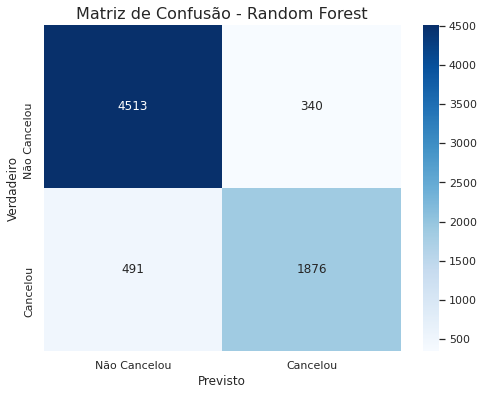

In [98]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
metrics_rf = calculate_metrics('Random Forest', y_test, rf_pred)
evaluate_model(rf, X_test, y_test, model_name='Random Forest')

In [99]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [74]:
rf_cv = cross_validation_kfold(rf, X, y, k=5)
rf_cv

,Model,Precision,Recall,Accuracy
0,RandomForestClassifier,0.854524,0.799713,0.889692


## 6.2 Decision Tree

--- Métricas de Avaliação para: Decision Tree ---
Acurácia: 0.8633
Precisão (Precision): 0.7964
Recall (Sensibilidade): 0.7833
F1-Score: 0.7898
AUC (Area Under the Curve): 0.8509
-----------------------------------------------------


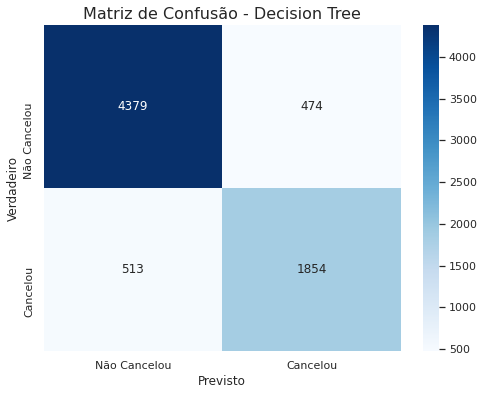

In [76]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)

dt_pred = dt.predict(X_test)
metrics_dt = calculate_metrics('Decision Tree', y_test, dt_pred)
evaluate_model(dt, X_test, y_test, model_name='Decision Tree')

### 6.2.1 Decision Tree CV

In [77]:
dt_cv = cross_validation_kfold(dt, X, y, k=5)
dt_cv

,Model,Precision,Recall,Accuracy
0,DecisionTreeClassifier,0.793652,0.791937,0.864262


## 6.3 LightGBM

--- Métricas de Avaliação para: LightGBM ---
Acurácia: 0.8727
Precisão (Precision): 0.8415
Recall (Sensibilidade): 0.7537
F1-Score: 0.7952
AUC (Area Under the Curve): 0.9348
------------------------------------------------


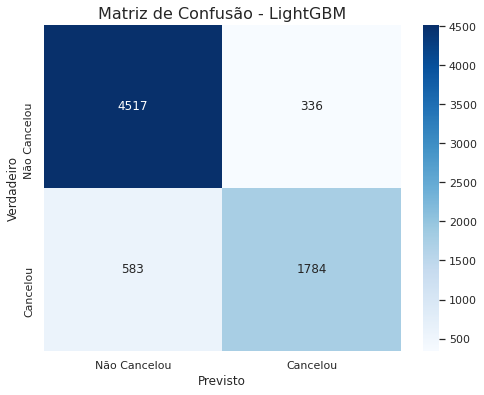

In [78]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

lgbm_pred = lgbm.predict(X_test)
metrics_lgbm = calculate_metrics('LightGBM', y_test, lgbm_pred)
evaluate_model(lgbm, X_test, y_test, model_name='LightGBM')

### 6.3.1 LightGBM CV

In [79]:
lightgbm_cv = cross_validation_kfold(lgbm, X, y, k=5)
lightgbm_cv

,Model,Precision,Recall,Accuracy
0,LGBMClassifier,0.844233,0.761142,0.875647


## 6.4 XGBoost

--- Métricas de Avaliação para: XGBoost ---
Acurácia: 0.8348
Precisão (Precision): 0.7906
Recall (Sensibilidade): 0.6747
F1-Score: 0.7281
AUC (Area Under the Curve): 0.9019
-----------------------------------------------


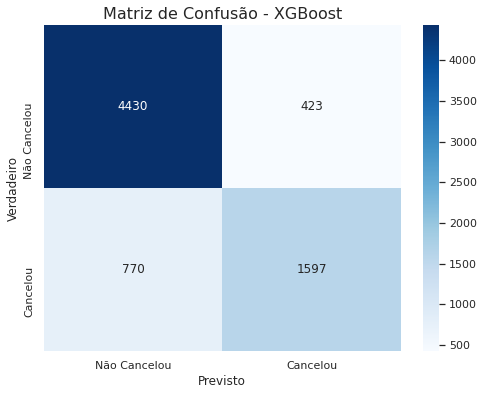

In [80]:
import xgboost as xgb

xgb = xgb.XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)
metrics_xgb = calculate_metrics('XGBoost', y_test, xgb_pred)
evaluate_model(xgb, X_test, y_test, model_name='XGBoost')


### 6.4.1 XGBoost CV

In [81]:
xgb_cv = cross_validation_kfold(xgb, X, y, k=5)
xgb_cv

,Model,Precision,Recall,Accuracy
0,XGBClassifier,0.794132,0.683958,0.838195


## 6.5 Logistic Regression

--- Métricas de Avaliação para: Logistic Regression ---
Acurácia: 0.8021
Precisão (Precision): 0.7415
Recall (Sensibilidade): 0.6084
F1-Score: 0.6684
AUC (Area Under the Curve): 0.8495
-----------------------------------------------------------


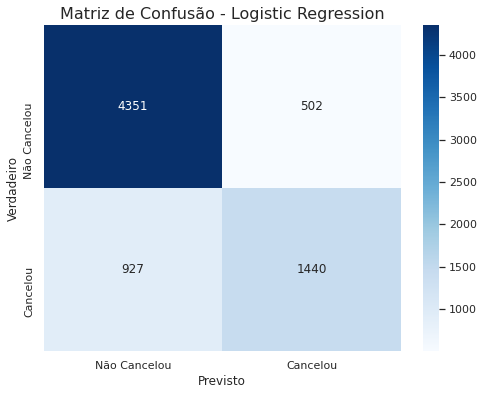

In [82]:
from sklearn.linear_model import LogisticRegression    

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)
metrics_lr = calculate_metrics('Logistic Regression', y_test, lr_pred)
evaluate_model(lr, X_test, y_test, model_name='Logistic Regression')

### 6.5.1 LR CV

In [83]:
lr_cv = cross_validation_kfold(lr, X, y, k=5)   
lr_cv

,Model,Precision,Recall,Accuracy
0,LogisticRegression,0.743242,0.600947,0.801102


## Resultados

In [84]:
df_metrics = pd.concat([metrics_rf, metrics_dt, metrics_lgbm, metrics_xgb, metrics_lr], ignore_index=True).sort_values(by='Recall', ascending=False)
df_metrics

,Algoritmo,Precisão,Recall,Acurácia
0,Random Forest,0.846570,0.792564,0.884903
1,Decision Tree,0.796392,0.783270,0.863296
2,LightGBM,0.841509,0.753697,0.872715
3,XGBoost,0.790594,0.674694,0.834765
4,Logistic Regression,0.741504,0.608365,0.802078


## Resultados CV

In [85]:
df_metrics_cv = pd.concat([rf_cv, dt_cv, lightgbm_cv, xgb_cv, lr_cv], ignore_index=True).sort_values(by='Recall', ascending=False)
df_metrics_cv

,Model,Precision,Recall,Accuracy
0,RandomForestClassifier,0.854524,0.799713,0.889692
1,DecisionTreeClassifier,0.793652,0.791937,0.864262
2,LGBMClassifier,0.844233,0.761142,0.875647
3,XGBClassifier,0.794132,0.683958,0.838195
4,LogisticRegression,0.743242,0.600947,0.801102


# 7.0 Fine Tunning

## 7.1 Bayes Search

In [86]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [104]:
# Função de avaliação para o modelo Random Forest
def rfc_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)

    rfc = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    rfc.fit(X_train, y_train)
    
    cv_results = cross_val_score(rfc, X_train, y_train, cv=5, scoring='recall').mean()

    return cv_results

pbounds = {
    'n_estimators': (50, 200),           
    'max_depth': (3, 10),                
    'min_samples_split': (2, 10),        
    'min_samples_leaf': (1, 10)         
}

optimizer = BayesianOptimization(
    f=rfc_cv,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(
    init_points=5,
    n_iter=30
)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------


| 1         | 0.6315    | 5.622     | 9.556     | 7.856     | 139.8     |
| 2         | 0.5714    | 4.092     | 2.404     | 2.465     | 179.9     |
| 3         | 0.683     | 7.208     | 7.373     | 2.165     | 195.5     |
| 4         | 0.7048    | 8.827     | 2.911     | 3.455     | 77.51     |
| 5         | 0.634     | 5.13      | 5.723     | 5.456     | 93.68     |
| 6         | 0.7074    | 8.062     | 7.013     | 3.783     | 59.58     |
| 7         | 0.4165    | 3.345     | 1.166     | 6.804     | 158.6     |
| 8         | 0.4224    | 3.031     | 1.363     | 5.732     | 102.8     |
| 9         | 0.7268    | 9.796     | 7.386     | 9.951     | 106.1     |
| 10        | 0.6644    | 6.301     | 2.444     | 8.416     | 64.48     |
| 11        | 0.7267    | 9.673     | 6.865     | 9.046     | 108.4     |
| 12        | 0.7258    | 9.48      | 6.675     | 2.0       | 69.03     |
| 13        | 0.7387    | 10.0      | 10.0      | 9.339     | 73.77     |
| 14        | 0.4183    | 3.0       | 

In [105]:
print("Melhores parâmetros encontrados:")
print(optimizer.max)

Melhores parâmetros encontrados:
{'target': 0.7496560718614849, 'params': {'max_depth': 10.0, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 86.76089778116045}}


In [110]:
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])

best_model_bayes = RandomForestClassifier(**best_params, random_state=42)
best_model_bayes.fit(X_train, y_train)
y_pred_bayes = best_model_bayes.predict(X_test)
metrics_best_model_bayes = calculate_metrics('Best Model (Bayesian Optimization)', y_test, y_pred_bayes)
metrics_best_model_bayes

,Algoritmo,Precisão,Recall,Acurácia
0,Best Model (Bayesian Optimization),0.841452,0.744402,0.870222


# 8.0 Modelo Final

In [113]:
model_tunned = RandomForestClassifier(**best_params, random_state=42).fit(X_train, y_train)
y_pred = model_tunned.predict(X_test)

metrics_model_tunned = calculate_metrics('Model Tuned', y_test, y_pred)
metrics_model_tunned.round(2)

,Algoritmo,Precisão,Recall,Acurácia
0,Model Tuned,0.84,0.74,0.87


In [114]:
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

In [116]:
final_model = RandomForestClassifier(**best_params, random_state=42).fit(X_full, y_full)

In [117]:
import pickle
pickle.dump(final_model, open('models/final_model.pkl', 'wb'))

# 9.0 Model Business Results

In [122]:
# Métricas do modelo
recall = 0.74
precision = 0.84

# Cenário base
total_reservas = 50000
taxa_cancelamento_hist = 0.32
custo_cancelamento = 3500

# Quantidade de cancelamentos esperados historicamente
cancelamentos_esperados = total_reservas * taxa_cancelamento_hist

# Cancelamentos corretamente identificados (True Positives)
true_positives = cancelamentos_esperados * recall

# Falsos positivos (previu cancelamento, mas era reserva válida)
false_positives = true_positives * (1 - precision) / precision

# Total de previsões de cancelamento
total_prev_cancel = true_positives + false_positives

# Economia: cada cancelamento previsto corretamente pode evitar custo (via ação preventiva)
economia_potencial = true_positives * custo_cancelamento

# Perda por ações indevidas - Contato desnecessário com clientes que não cancelaram
perda_potencial = false_positives * custo_cancelamento

# Economia líquida
economia_liquida = economia_potencial - perda_potencial

# Resultados
print(f"Cancelamentos esperados: {cancelamentos_esperados:.0f}")
print(f"Cancelamentos previstos corretamente (TP): {true_positives:.0f}")
print(f"Falsos positivos: {false_positives:.0f}")
print(f"Economia potencial: R$ {economia_potencial:,.2f}")
print(f"Perda potencial: R$ {perda_potencial:,.2f}")
print(f"💰 Economia líquida estimada: R$ {economia_liquida:,.2f}")


Cancelamentos esperados: 16000
Cancelamentos previstos corretamente (TP): 11840
Falsos positivos: 2255
Economia potencial: R$ 41,440,000.00
Perda potencial: R$ 7,893,333.33
💰 Economia líquida estimada: R$ 33,546,666.67


# 10.0 Deploy

## Class

In [134]:
class PredictReservas(object):
    def __init__(self):

        # columns to be used for prediction: ['lead_time', 'market_segment_type', 'avg_price_per_room', 'no_of_special_requests', 'week_of_year']

        self.model = pickle.load(open('models/final_model.pkl', 'rb'))
        self.market_segment_type_encoder = pickle.load(open('parameters/label_encoder_market_segment_type.pkl', 'rb'))
        self.avg_price_scaler = pickle.load(open('parameters/scaler_avg_price_per_room.pkl', 'rb'))
        self.no_of_special_requests_scaler = pickle.load(open('parameters/scaler_no_of_special_requests.pkl', 'rb'))
        self.week_of_year_scaler = pickle.load(open('parameters/scaler_week_of_year.pkl', 'rb'))

    def data_cleaning(self, df1):

        # Filtra dados para no_of_adults > 0 
        df1 = df1[df1['no_of_adults'] > 0]
        
        return df1
        
    def feature_engineering(self, df2):
        
        df2['total_nights'] = df2['no_of_weekend_nights'] + df2['no_of_week_nights']
        df2['total_guests'] = df2['no_of_adults'] + df2['no_of_children']
        df2['family_trip'] = df2.apply(lambda x: 1 if x['no_of_children'] > 0 else 0, axis=1)

        df2['arrival_date_full'] = pd.to_datetime(
            df2['arrival_year'].astype(str) + '/' +
            df2['arrival_month'].astype(str) + '/' +
            df2['arrival_date'].astype(str),
            errors='coerce'
        )

        df2['day_of_week'] = df2['arrival_date_full'].dt.dayofweek
        df2['week_of_year'] = df2['arrival_date_full'].dt.isocalendar().week 

        numerator = df2['no_of_previous_cancellations']
        denominator = df2['no_of_previous_cancellations'] + df2['no_of_previous_bookings_not_canceled']
        df2['cancellation_ratio_previous'] = numerator / denominator

        df2['cancellation_ratio_previous'].fillna(0, inplace=True)

        return df2
    
    def data_preparation(self, df3):
        
        # Target

        # Seleciona colunas para previsão
        df3 = df3[['lead_time', 'market_segment_type', 'avg_price_per_room', 'no_of_special_requests', 'week_of_year']]

        # Rescale
        df3['avg_price_per_room'] = self.avg_price_scaler.transform(df3[['avg_price_per_room']])
        df3['no_of_special_requests'] = self.no_of_special_requests_scaler.transform(df3[['no_of_special_requests']])
        df3['week_of_year'] = self.week_of_year_scaler.transform(df3[['week_of_year']])
        
        # Encode market_segment_type
        df3['market_segment_type'] = self.market_segment_type_encoder.transform(df3['market_segment_type'])

        return df3
    
    def get_predictions(self, model, test_data, original_data):

        pred = model.predict(test_data)
        original_data['prediction'] = pred

        return original_data.to_json(orient='records')

## API Handler

In [ ]:
from flask import Flask, request, Response
import os

model = pickle.load(open('models/final_model.pkl', 'rb'))

app = Flask(__name__)   

@app.route('/hotelsmart/predict', methods=['POST'])
def emprestimo_predict():
    test_json = request.get_json()

    if test_json:
        if isinstance(test_json, dict):
            test_raw= pd.DataFrame(test_json, index=[0])
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        pipeline = PredictReservas()
        test_cleaned = pipeline.data_cleaning(test_raw)
        test_engineered = pipeline.feature_engineering(test_cleaned)
        test_prepared = pipeline.data_preparation(test_engineered)
        predictions = pipeline.get_predictions(model, test_prepared, test_raw)

        return predictions
    else:
        return Response('{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    port = int(os.environ.get('PORT', 5000))
    app.run(host='0.0.0', port=port, debug=True)

## Teste API

In [145]:
import requests
import json

In [130]:
data_test = df1.loc[df1.index == 20]
model = pickle.load(open('models/final_model.pkl', 'rb'))

In [135]:
pipeline = PredictReservas()
df_cleaning = pipeline.data_cleaning(data_test)
df_engineered = pipeline.feature_engineering(df_cleaning)
df_prepared = pipeline.data_preparation(df_engineered)
df_predict = pipeline.get_predictions(model, df_prepared, data_test)

<ipython-input-134-4fd185a12e28>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['avg_price_per_room'] = self.avg_price_scaler.transform(df3[['avg_price_per_room']])
<ipython-input-134-4fd185a12e28>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['no_of_special_requests'] = self.no_of_special_requests_scaler.transform(df3[['no_of_special_requests']])
<ipython-input-134-4fd185a12e28>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [180]:
# # Local
# data_test = df1.loc[df1.index == 1]

# # Local
# url = 'http://127.0.0.1:5000/hotelsmart/predict'
# header = {'Content-Type': 'application/json'}
# data = json.dumps(data_test.to_dict('records'))

# r = requests.post(url, data=data, headers=header)
# print('Status Code:', r.status_code)

In [186]:
# Koyeb
data_test = df1.loc[df1.index == 20]

# Local
url = 'https://political-squid-feliperastelli-97cad387.koyeb.app/hotelsmart/predict'
header = {'Content-Type': 'application/json'}
data = json.dumps(data_test.to_dict('records'))

r = requests.post(url, data=data, headers=header)
print('Status Code:', r.status_code)

Status Code: 200


In [187]:
data

'[{"Booking_ID": "INN00021", "no_of_adults": 2, "no_of_children": 0, "no_of_weekend_nights": 2, "no_of_week_nights": 2, "type_of_meal_plan": "Meal Plan 1", "required_car_parking_space": 0, "room_type_reserved": "Room_Type 1", "lead_time": 99, "arrival_year": 2017, "arrival_month": 10, "arrival_date": 30, "market_segment_type": "Online", "repeated_guest": 0, "no_of_previous_cancellations": 0, "no_of_previous_bookings_not_canceled": 0, "avg_price_per_room": 65.0, "no_of_special_requests": 0, "booking_status": "Canceled"}]'

In [185]:
payload = '[{"no_of_adults":3,"no_of_children":0,"no_of_weekend_nights":0,"no_of_week_nights":0,"type_of_meal_plan":"Meal Plan 1","required_car_parking_space":0,"room_type_reserved":"Room_Type 6","lead_time":0,"arrival_year":2020,"arrival_month":3,"arrival_date":6,"market_segment_type":"Online","repeated_guest":0,"no_of_previous_cancellations":1,"no_of_previous_bookings_not_canceled":2,"avg_price_per_room":106.68,"no_of_special_requests":4}]'
r = requests.post(url, data=payload, headers={'Content-Type': 'application/json'})
print(r.status_code)
print(r.text)


200
[{"no_of_adults":3,"no_of_children":0,"no_of_weekend_nights":0,"no_of_week_nights":0,"type_of_meal_plan":"Meal Plan 1","required_car_parking_space":0,"room_type_reserved":"Room_Type 6","lead_time":0,"arrival_year":2020,"arrival_month":3,"arrival_date":6,"market_segment_type":"Online","repeated_guest":0,"no_of_previous_cancellations":1,"no_of_previous_bookings_not_canceled":2,"avg_price_per_room":106.68,"no_of_special_requests":4,"prediction":0}]
